#### AKADEMIA GÓRNICZO-HUTNICZA IM. STANISŁAWA STASZICA W KRAKOWIE
#### WYDZIAŁ ZARZĄDZANIA
#### KATEDRA ZASTOSOWAŃ MATEMATYKI W EKONOMII

# Praca dyplomowa

## Analiza porównawcza wybranych modeli uczenia maszynowego i klasycznych technik ekonometrycznych w prognozowaniu zmienności rynków finansowych
## Comparative analysis of selected machine learning models and classical econometric techniques in forecasting financial market volatility

### Autor: Hanna Kinga Waligóra
### Kierunek studiów:	Informatyka i ekonometria 
###  Opiekun pracy:	dr hab. Łukasz Lach, prof. uczelni


# Import bibliotek

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import statsmodels.api as sm
from arch.utility.exceptions import ConvergenceWarning, DataScaleWarning
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataScaleWarning)

# Fukncje do przygotowania i analizy danych

In [3]:
# 1) POBIERANIE DANYCH I WYBÓR OKRESÓW

# Funkcja do pobierania danych dotyczących indeksów ze strony Stooq.pl, zapisuje pełne pliki CSV do folderu indeksy_full.
# Do jej wywołania potrzebny jest ticker_map: dict, np. {'spx': '^spx', 'bvp': '^bvp'}, dzięki czemu zapisuje pliki jako np. SPX_FULL.csv (bez ^), mimo że używa ^ do pobierania ze Stooq.
def download_stooq_data_mapped(ticker_map, output_dir='indeksy_full'):
    os.makedirs(output_dir, exist_ok=True)

    for ticker, stooq_symbol in ticker_map.items():
        url = f'https://stooq.pl/q/d/l/?s={stooq_symbol}&i=d'
        safe_ticker = ticker.replace('^', '')  # zapisz bez ^
        output_file = os.path.join(output_dir, f"{safe_ticker.upper()}_FULL.csv")

        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()

            with open(output_file, 'wb') as f:
                f.write(response.content)

            print(f"Pobrano dane dla {ticker.upper()} ({stooq_symbol}) → {output_file}")

        except Exception as e:
            print(f"Błąd przy pobieraniu {ticker.upper()}: {e}")

# Funkcja, która tnie pełne pliki na okresy i zapisuje do folderu indeksy, dzieląc na podfoldery stabilny, niestabilny.
def slice_periods_to_csv(tickers, periods, input_dir='indeksy_full', output_dir='indeksy'):
    os.makedirs(output_dir, exist_ok=True)

    for ticker in tickers:
        full_path = os.path.join(input_dir, f"{ticker.upper()}_FULL.csv")
        if not os.path.exists(full_path):
            print(f"Brak pliku: {full_path}. Najpierw uruchom download_stooq_data(...).")
            continue

        df = pd.read_csv(full_path)
        if 'Data' not in df.columns:
            raise ValueError(f"Brak kolumny 'Data' w pliku dla {ticker.upper()}. Kolumny: {df.columns.tolist()}")

        df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
        df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)

        for label, (start_date, end_date) in periods.items():
            subdir = os.path.join(output_dir, label)
            os.makedirs(subdir, exist_ok=True)

            mask = (df['Data'] >= pd.to_datetime(start_date)) & (df['Data'] <= pd.to_datetime(end_date))
            df_slice = df.loc[mask].reset_index(drop=True)

            safe_ticker = ticker.replace('^', '')
            out_path = os.path.join(subdir, f"{safe_ticker.upper()}_{label}.csv")
            df_slice.to_csv(out_path, index=False)
            print(f"[{ticker.upper()}] zapisano {label}: {out_path} (wierszy: {len(df_slice)})")


# 2) PRZYGOTOWANIE DANYCH I OBLICZENIA

# Funkcja do wczytywania danych do DataFrame, przygotowuje ramkę danych z datą oraz ceną zamknięcia.
def prepare_index_data(file_path: str, column_name: str = 'Zamkniecie') -> pd.DataFrame:
    df = pd.read_csv(file_path)
    # Do analizy potrzebne będą tylko kolumny: Data i Zamkniecie
    if 'Data' not in df.columns or column_name not in df.columns:
        raise ValueError(f"Plik {file_path} nie zawiera wymaganych kolumn: 'Data' i '{column_name}'. "
                         f"Kolumny: {df.columns.tolist()}")
    df = df[['Data', column_name]].copy()
    df.rename(columns={column_name: 'Zamkniecie'}, inplace=True)
    # Konwersja daty na typ datetime
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)
    return df

# Funkcja obliczająca logarytmiczne stopy zwrotu na podstawie cen zamknięcia.
def compute_log_returns(df: pd.DataFrame, index_name: str = '') -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values('Data')  # upewniamy się, że dane są w kolejności czasowej
    if 'Zamkniecie' not in df.columns:
        raise ValueError("Brak kolumny 'Zamkniecie' do wyliczenia logarytmicznej stopy zwrotu.")
    df['Log_stopa_zwrotu'] = np.log(df['Zamkniecie'] / df['Zamkniecie'].shift(1))
    df = df[['Data', 'Log_stopa_zwrotu']].dropna().reset_index(drop=True)
    return df

# Funkcja do obliczania rocznej (annualizowanej) zmienność historycznej na podstawie logarytmicznych stóp zwrotu.
def compute_realized_volatility(
    df: pd.DataFrame,
    return_col: str = 'Log_stopa_zwrotu',
    window: int = 21,
    new_col: str = 'RV_21',
    annualize: bool = True
) -> pd.DataFrame:
    df = df.copy()
    df[new_col] = df[return_col].rolling(window=window).std()
    if annualize:
        df[new_col] = df[new_col] * np.sqrt(252)
    return df

# Funkcja, która wczytuje pocięty plik okresu, liczy logarytmiczne stopy zwrotu i roczną zmienność historyczną oraz zapisuje processed CSV.
def process_period_file_to_csv(input_path: str, output_path: str, rv_window: int = 21, annualize: bool = True):
    df0 = prepare_index_data(input_path, column_name='Zamkniecie')
    df1 = compute_log_returns(df0)
    df2 = compute_realized_volatility(df1, return_col='Log_stopa_zwrotu', window=rv_window,
                                      new_col=f'RV_{rv_window}', annualize=annualize)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df2.to_csv(output_path, index=False)
    return df2


# Funkcja do wczytywania wszystkich plików za jednym razem.
def process_all_periods_to_csv(tickers, periods, input_dir='indeksy', output_dir='indeksy_przetworzone',
                               rv_window=21, annualize=True):
    processed = {}
    for ticker in tickers:
        for label in periods.keys():
            in_path = os.path.join(input_dir, label, f"{ticker.upper()}_{label}.csv")
            safe_ticker = ticker.replace('^', '')
            out_path = os.path.join(output_dir, label, f"{safe_ticker.upper()}_{label}_processed.csv")
            if not os.path.exists(in_path):
                print(f"Brak pliku wejściowego: {in_path}")
                continue
            df_proc = process_period_file_to_csv(in_path, out_path, rv_window=rv_window, annualize=annualize)
            processed[(ticker, label)] = df_proc
            print(f"[{ticker.upper()}] {label}: zapisano processed → {out_path} (wierszy: {len(df_proc)})")
    return processed

# Funkcja pomocnicza do wczytywania pojedyńczego pliku w celu obliczenia statystyk zbiorów.
# Zdefiniowanie potrzebnych  do funkcji parametrów.
BASE_DIR = 'indeksy_przetworzone'
PERIODS = ['stabilny', 'niestabilny']
TICKERS = ['WIG20', 'SPX', 'BVP']
RV_COL = 'RV_21'
RET_COL = 'Log_stopa_zwrotu'

def read_processed(ticker: str, label: str):
    path = os.path.join(BASE_DIR, label, f"{ticker}_{label}_processed.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Brak pliku: {path}")
    df = pd.read_csv(path)
    if 'Data' not in df.columns or RET_COL not in df.columns or RV_COL not in df.columns:
        raise ValueError(f"Plik {path} musi zawierać kolumny: Data, {RET_COL}, {RV_COL}. "
                         f"Znaleziono: {df.columns.tolist()}")
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)
    return df

# Funkcja, która wykonuje wykres porównujący zmienność dla dwóch okresów (stabilnego i niestabilnego) dla podanego indeksu giełdowego.
def plot_rv_two_regimes(index_ticker: str, periods_labels=('okres stabilny','okres niestabilny'),
                        processed_dir='indeksy_przetworzone', rv_col='RV_21'):
    import matplotlib.pyplot as plt
    data = {}
    for label in periods_labels:
        path = os.path.join(processed_dir, label, f"{index_ticker.upper()}_{label}_processed.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Brak pliku: {path}. Uruchom wcześniej process_all_periods_to_csv(...).")
        df = pd.read_csv(path)
        if 'Data' not in df.columns:
            raise ValueError(f"Plik {path} nie ma kolumny 'Data'.")
        df['Data'] = pd.to_datetime(df['Data'])
        data[label] = df

    plt.figure(figsize=(12, 5))
    for label, df in data.items():
        plt.plot(df['Data'], df[rv_col], label=f'{index_ticker.upper()} – {label}')
    plt.title(f'Roczna zmienność historyczna – {index_ticker.upper()}\nPorównanie: okres {periods_labels[0]} vs okres {periods_labels[1]}')
    plt.xlabel('Data')
    plt.ylabel('Roczna zmienność historyczna')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Funkcje do algorytmu Random Forest
# Funkcja dodająca zmienne techniczne do ramki danych w celu budowy Radnom Forest
def add_tech_features(df, price_col='Zamkniecie'):
    df = df.copy()

    # MA – średnie kroczące
    df['MA_21'] = df[price_col].rolling(window=21).mean()
    df['MA_63'] = df[price_col].rolling(window=63).mean()

    # RSI(14)
    delta = df[price_col].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # MACD: EMA12 - EMA26, różnica z sygnałem (EMA9 z MACD)
    ema12 = df[price_col].ewm(span=12, adjust=False).mean()
    ema26 = df[price_col].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = macd - signal

    return df

# Funkcja uzupełniają w df kolumny: MA_5, MA_22, RSI_14, MACD, MACD_signal, jeśli ich brakuje (nie nadpisuje istniejących). Zwraca skopiowaną ramkę danych.
def ensure_tech_features(df: pd.DataFrame,
                         price_col='Zamkniecie',
                         rv_col='RV_21',
                         ma_fast=5, ma_slow=22,
                         rsi_period=14,
                         macd_fast=12, macd_slow=26, macd_signal=9):
    d = df.copy()
    if 'Data' not in d.columns:
        raise ValueError("Brak kolumny 'Data'.")
    if price_col not in d.columns:
        raise ValueError(f"Brak kolumny ceny: {price_col}")

    d = d.sort_values('Data').reset_index(drop=True)

    # MA
    if 'MA_5' not in d.columns:
        d['MA_5'] = d[price_col].rolling(ma_fast).mean()
    if 'MA_22' not in d.columns:
        d['MA_22'] = d[price_col].rolling(ma_slow).mean()

    # RSI
    if 'RSI_14' not in d.columns:
        delta = d[price_col].diff()
        up = np.where(delta > 0, delta, 0.0)
        down = np.where(delta < 0, -delta, 0.0)
        roll_up = pd.Series(up, index=d.index).rolling(rsi_period).mean()
        roll_dn = pd.Series(down, index=d.index).rolling(rsi_period).mean()
        rs = roll_up / (roll_dn + 1e-12)
        d['RSI_14'] = 100.0 - (100.0 / (1.0 + rs))

    # MACD
    if 'MACD' not in d.columns or 'MACD_signal' not in d.columns:
        ema_fast = d[price_col].ewm(span=macd_fast, adjust=False).mean()
        ema_slow = d[price_col].ewm(span=macd_slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        macd_sig = macd.ewm(span=macd_signal, adjust=False).mean()
        if 'MACD' not in d.columns:
            d['MACD'] = macd
        if 'MACD_signal' not in d.columns:
            d['MACD_signal'] = macd_sig

    return d

# Funkcje do budowy modeli

In [4]:
# === HAR ===
# Prognoza 1 dzień do przodu na oknie rozszerzającym.
# Funkcja buduje cechy HAR (RV_D, RV_W, RV_M) z przesunięciem o 1 dzień (brak wycieku), a następnie wykonuje prognozę 1-dnia-naprzód w trybie walk-forward.
def har_expanding_aligned(df: pd.DataFrame, rv_col='RV_21', initial_train_size=252):
    d = df.copy().sort_values('Data').reset_index(drop=True)

    # cechy HAR
    d['RV_D'] = d[rv_col]                         # dzienna
    d['RV_W'] = d[rv_col].rolling(5).mean()       # tygodniowa
    d['RV_M'] = d[rv_col].rolling(22).mean()      # miesięczna

    # przesunięcie o 1 dzień – prognoza zmienności bazuje na informacjach ≤ t-1
    for c in ['RV_D', 'RV_W', 'RV_M']:
        d[c] = d[c].shift(1)

    # wektory danych
    dates  = d['Data'].to_numpy()
    y_true = d[rv_col].to_numpy(dtype=float)
    X_all  = d[['RV_D','RV_W','RV_M']].to_numpy(dtype=float)

    # maska: pełny zestaw cech + zmienna objaśniana
    have_feats  = ~np.isnan(X_all).any(axis=1)
    have_target = ~np.isnan(y_true)
    valid_idx   = np.where(have_feats & have_target)[0]
    if len(valid_idx) == 0:
        raise RuntimeError("Brak obserwacji z kompletnym zestawem cech i targetu dla HAR.")

    first_valid_idx = int(valid_idx[0])
    start = max(int(initial_train_size), first_valid_idx)

    y_pred = np.full(len(dates), np.nan, dtype=float)

    # okno rozszerzające – walk-forward
    for t in range(start, len(dates)):
        if not (have_feats[t] and have_target[t]):
            continue
        mask_tr = (np.arange(t) < t) & have_feats[:t] & have_target[:t]
        Xtr, ytr = X_all[:t][mask_tr], y_true[:t][mask_tr]
        Xte      = X_all[t:t+1]

        Xtr_c = sm.add_constant(Xtr, has_constant='add')
        Xte_c = sm.add_constant(Xte, has_constant='add')

        model = sm.OLS(ytr, Xtr_c).fit()
        y_pred[t] = np.asarray(model.predict(Xte_c)).ravel()[0]

    m = ~np.isnan(y_pred)
    return dates[m], y_true[m], y_pred[m]

# === HAR (predict_all) ===
# Uruchamia HAR dla wielu indeksów i okresów (stabilny/niestabilny). Wczytuje dane z plików CSV, uruchamia har_expanding_aligned i zwraca prognozy.
# === HAR – predykcje dla wielu indeksów i okresów + zapis wyniku globalnie ===
def har_predict_all(tickers=('WIG20','SPX','BVP'),
                    periods=('stabilny','niestabilny'),
                    base_dir='indeksy_przetworzone',
                    rv_col='RV_21',
                    initial_train_size=252,
                    save_global=True):
    results = {}
    for tic in tickers:
        t_u = tic.upper()
        for label in periods:
            path = os.path.join(base_dir, label, f"{t_u}_{label}_processed.csv")
            if not os.path.exists(path):
                print(f"[WARN] Brak pliku: {path}")
                continue

            df = pd.read_csv(path)
            if 'Data' not in df.columns:
                raise ValueError(f"Plik {path} nie ma kolumny 'Data'.")
            df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
            df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)


            dates, y_true, y_pred = har_expanding_aligned(
                df, rv_col=rv_col, initial_train_size=initial_train_size
            )

            # R² z prognoz walk-forward (dla całej próbki testowej)
            r2 = float(r2_score(y_true, y_pred)) if len(y_true) > 1 else float('nan')

            results[(tic, label)] = {
                'dates': dates,
                'true':  y_true,
                'pred':  y_pred,
                'r2':    r2,
            }

            print(f"[OK] HAR zrobiony: {tic}, {label} (n={len(dates)}), R²={r2:.3f}")

            dates, y_true, y_pred = har_expanding_aligned(
                df, rv_col=rv_col, initial_train_size=initial_train_size
            )
            results[(tic, label)] = {'dates': dates, 'true': y_true, 'pred': y_pred}
            print(f"[OK] HAR zrobiony: {tic}, {label} (n={len(dates)})")

    # zapis globalny, wyników, w celu sprawdzenia dopasowania modelu
    if save_global:
        globals()['har_results'] = results

    return results


# === GARCH ===
# Prognoza 1 dzień do przodu w oknie rozszerzającym. Funkcja dla każdego t dopasowuje GARCH(1,1), prognozuje 1-step-ahead i porównuje z wartością rzeczywistą (walk-forward).
def garch_expanding_aligned(df: pd.DataFrame,
                            rv_col='RV_21',
                            ret_col='Log_stopa_zwrotu',
                            initial_train_size=252,
                            scale_factor=100.0,
                            mean_spec='Zero',
                            dist='normal',
                            annualize=True):
    d = df.copy().sort_values('Data').reset_index(drop=True)

    if 'Data' not in d.columns:
        raise ValueError("Brak kolumny 'Data'.")
    if rv_col not in d.columns:
        raise ValueError(f"Brak kolumny '{rv_col}'.")
    if ret_col not in d.columns:
        raise ValueError(f"Brak kolumny '{ret_col}'.")

    dates  = d['Data'].to_numpy()
    rv     = d[rv_col].to_numpy(dtype=float)   # zmienność (zmienna objaśniana)
    ret    = d[ret_col].to_numpy(dtype=float)  # stopy zwrotu (zmienne objaśniające)

    # maska: pełne dane
    have_rv   = ~np.isnan(rv)
    have_ret  = ~np.isnan(ret)

    # start = max(pierwsza dostępna obserwacja i początkowe okno treningowe)
    first_valid_idx = max(
        initial_train_size,
        int(np.where(have_rv)[0][0]) if np.any(have_rv) else initial_train_size
    )

    y_pred = np.full(len(dates), np.nan, dtype=float)

    # okno rozszerzające – walk-forward
    for t in range(first_valid_idx, len(d)):
        if not (np.all(have_ret[:t]) and have_rv[t]):
            continue

        # skalowanie stóp zwrotu dla stabilności numerycznej
        r_train_scaled = ret[:t] * scale_factor  
        am = arch_model(r_train_scaled,
                        mean=mean_spec.lower(),
                        vol='garch',
                        p=1, o=0, q=1,
                        dist=dist)
        res = am.fit(disp='off') 

        fcast = res.forecast(horizon=1, reindex=False)
        var_scaled = float(fcast.variance.values[-1, 0])
        var_true = var_scaled / (scale_factor**2)     # odskala
        sigma = np.sqrt(var_true)                     # dzienne odchylenie

        if annualize:
            sigma *= np.sqrt(252.0)                   # annualizacja

        y_pred[t] = sigma

    m = ~np.isnan(y_pred) & ~np.isnan(rv)
    return dates[m], rv[m], y_pred[m]


# === GARCH (predict_all) ===
# Uruchamia GARCH dla wielu indeksów i okresów (stabilny/niestabilny). Wczytuje dane z plików CSV, uruchamia garch_expanding_aligned i zwraca prognozy.
def garch_predict_all(tickers=('WIG20','SPX','BVP'),
                      periods=('stabilny','niestabilny'),
                      base_dir='indeksy_przetworzone',
                      rv_col='RV_21',
                      ret_col='Log_stopa_zwrotu',
                      initial_train_size=252,
                      scale_factor=100.0,
                      mean_spec='Zero',
                      dist='normal',
                      annualize=True,
                      save_global=True):
    results = {}
    for tic in tickers:
        t_u = tic.upper()
        for label in periods:
            path = os.path.join(base_dir, label, f"{t_u}_{label}_processed.csv")
            if not os.path.exists(path):
                print(f"[WARN] Brak pliku: {path}")
                continue

            df = pd.read_csv(path)
            if 'Data' not in df.columns:
                raise ValueError(f"Plik {path} nie ma kolumny 'Data'.")
            df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
            df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)

            dates, y_true, y_pred = garch_expanding_aligned(
                df, rv_col=rv_col, ret_col=ret_col,
                initial_train_size=initial_train_size,
                scale_factor=scale_factor, mean_spec=mean_spec,
                dist=dist, annualize=annualize
            )
            results[(tic, label)] = {'dates': dates, 'true': y_true, 'pred': y_pred}
            print(f"[OK] GARCH zrobiony: {tic}, {label} (n={len(dates)})")

    if save_global:
        globals()['garch_results'] = results

    return results


# === Random Forest ===
# Prognoza 1 dzień do przodu przy użyciu lasu losowego. Model korzysta z opóźnionych wskaźników technicznych i RV, a prognozowanie realizowane jest w trybie walk-forward.
def rf_model(df: pd.DataFrame,
             rv_col='RV_21',
             initial_train_size=252,
             n_estimators=500,
             random_state=42):
    d = df.copy().sort_values('Data').reset_index(drop=True)

    # wymagane kolumny
    required_cols = ['Data', rv_col, 'MA_5', 'MA_22', 'RSI_14', 'MACD', 'MACD_signal']
    for col in required_cols:
        if col not in d.columns:
            raise ValueError(f"Brakuje kolumny: {col}")

    # przesunięcie o 1 dzień (brak wycieku informacji)
    d['MA_5_lag']     = d['MA_5'].shift(1)
    d['MA_22_lag']    = d['MA_22'].shift(1)
    d['RSI_14_lag']   = d['RSI_14'].shift(1)
    d['MACD_lag']     = d['MACD'].shift(1)
    d['MACD_sig_lag'] = d['MACD_signal'].shift(1)
    d['RV_lag']       = d[rv_col].shift(1)

    feat_cols = ['MA_5_lag', 'MA_22_lag', 'RSI_14_lag', 'MACD_lag', 'MACD_sig_lag', 'RV_lag']

    dates  = d['Data'].to_numpy()
    y_true = d[rv_col].to_numpy(dtype=float)
    X_all  = d[feat_cols].to_numpy(dtype=float)

    # maska: kompletne dane
    mask_feats  = ~np.isnan(X_all).any(axis=1)
    mask_target = ~np.isnan(y_true)
    mask        = mask_feats & mask_target
    first_valid_idx = np.argmax(mask)
    start = max(initial_train_size, first_valid_idx)

    y_pred = np.full(len(dates), np.nan)

    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)

    # okno rozszerzające – walk-forward
    for t in range(start, len(dates)):
        if not mask[t]:
            continue
        Xtr, ytr = X_all[:t][mask[:t]], y_true[:t][mask[:t]]
        Xte      = X_all[t:t+1]
        model.fit(Xtr, ytr)
        y_pred[t] = float(model.predict(Xte)[0])

    m = ~np.isnan(y_pred)
    return dates[m], y_true[m], y_pred[m]


# === Random Forest (predict_all) ===
# Uruchamia Random Forest dla wielu indeksów i okresów (stabilny/niestabilny). Wczytuje dane, zapewnia obecność cech technicznych, uruchamia rf_model i zwraca prognozy.
def rf_predict_all_selected(tickers=('WIG20','SPX','BVP'),
                            periods=('stabilny','niestabilny'),
                            base_dir='indeksy_przetworzone',
                            rv_col='RV_21',
                            initial_train_size=252,
                            n_estimators=500,
                            random_state=42,
                            save_global=True):
    results = {}
    for tic in tickers:
        t_u = tic.upper()
        for label in periods:
            path = os.path.join(base_dir, label, f"{t_u}_{label}_processed.csv")
            if not os.path.exists(path):
                print(f"[WARN] Brak pliku: {path}")
                continue

            df = pd.read_csv(path)
            if 'Data' not in df.columns:
                raise ValueError(f"Plik {path} nie ma kolumny 'Data'.")
            df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
            df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)

            # uzupełnij cechy techniczne, jeśli brakuje
            df_f = ensure_tech_features(df, price_col='Zamkniecie', rv_col=rv_col)

            dates, y_true, y_pred = rf_model(
                df_f,
                rv_col=rv_col,
                initial_train_size=initial_train_size,
                n_estimators=n_estimators,
                random_state=random_state
            )
            results[(tic, label)] = {
                'dates': dates, 'true': y_true, 'pred': y_pred, 'df_used': df_f
            }
            print(f"[OK] RF(selected) zrobiony: {tic}, {label} (n={len(dates)})")

    if save_global:
        globals()['rf_results'] = results

    return results

# Funkcje do oceny jakości prognoz

In [5]:
# Funkcja rysująca wykres porównawczy między rzeczywistą, a prognozowaną przed podany model zmiennością
def plot_true_vs_pred(dates, y_true, y_pred, title, model_label='Prognoza'):
    m = ~np.isnan(y_true) & ~np.isnan(y_pred)
    plt.figure(figsize=(12,5))
    plt.plot(dates[m], y_true[m], label='Rzeczywista wartość zmienności', linewidth=1.5)
    plt.plot(dates[m], y_pred[m], label=model_label, linewidth=1.2)
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Roczna zmienność historyczna')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Funkcja pomicnicza używająca do powyższej funkcji do rysowania dla wszystkich par (ticker, okres)
def plot_all_results(results: dict, model_label='HAR'):
    for (tic, label), d in results.items():
        title = f"{model_label} – {tic} ({label})"
        plot_true_vs_pred(d['dates'], d['true'], d['pred'], title, model_label=model_label)


# Funkcja obliczająca miary jakości prognoz (RMSE, MAE)
def compute_metrics(y_true, y_pred):
    """RMSE, MAE na wspólnych obserwacjach (bez NaN)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = ~np.isnan(y_true) & ~np.isnan(y_pred)
    yt, yp = y_true[m], y_pred[m]
    # błędy punktowe
    se = (yt - yp) ** 2          # błędy kwadratowe
    ae = np.abs(yt - yp)         # błędy bezwzględne

    # metryki
    rmse = float(np.sqrt(np.mean(se)))
    mae  = float(np.mean(ae))

    return {
        'RMSE': rmse,
        'MAE': mae,
    }

# Funkcja drukująca metryki dla wszystkich par (ticker, okres) z results.
def show_metrics_for_all(results: dict, header="=== METRYKI HAR ==="):
    print(header)
    for (tic, label), d in results.items():
        met = compute_metrics(d['true'], d['pred'])
        print(f"{tic} – {label}: {met}")


# Funkcja dołączająca kolumnę 'Zamkniecie' z danych FULL do processed i zapisująca zaktualizowane CSV.
def add_close_to_processed(tickers=('WIG20', 'SPX', 'BVP'),
                           periods=('stabilny', 'niestabilny'),
                           full_dir='indeksy',
                           processed_dir='indeksy_przetworzone'):
    for ticker in tickers:
        # załaduj dane pełne
        full_path = os.path.join(full_dir, f"{ticker}_FULL.csv")
        if not os.path.exists(full_path):
            print(f"Brak pliku: {full_path}")
            continue
        df_full = pd.read_csv(full_path)
        df_full['Data'] = pd.to_datetime(df_full['Data'], errors='coerce')
        df_full = df_full[['Data', 'Zamkniecie']].dropna()

        for period in periods:
            proc_path = os.path.join(processed_dir, period, f"{ticker}_{period}_processed.csv")
            if not os.path.exists(proc_path):
                print(f"Brak pliku: {proc_path}")
                continue

            df_proc = pd.read_csv(proc_path)
            df_proc['Data'] = pd.to_datetime(df_proc['Data'], errors='coerce')

            # Dołączenie ceny po dacie
            df_merged = pd.merge(df_proc, df_full, on='Data', how='left')
            df_merged = df_merged.dropna(subset=['Zamkniecie'])

            # Nadpisujemy plik
            df_merged.to_csv(proc_path, index=False)
            print(f"Zaktualizowano {proc_path} (dodano kolumnę 'Zamkniecie')")

# Funkcje do diagnostyki i oceny dopasowania modeli

In [6]:
# === MINI-DIAGNOSTYKA MODELI (HAR / GARCH / RF) NA GOTOWYCH PROGNOZACH ===
# Wymaga: har_results, garch_results, rf_results (słowniki z 'dates','true','pred'),
#         pliki CSV w strukturze: indeksy_przetworzone/<okres>/<TICKER>_<okres>_processed.csv

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor

# --- HELPERY ---

# Funkcja: zwraca podstawową diagnostykę na resztach (Ljung–Box i Jarque–Bera).
def _residual_tests(dates, y_true, y_pred, lb_lags=20):
    # ważne: pracujemy na Twoich już policzonych prognozach (bez ponownych obliczeń RMSE/MAE)
    s_true = pd.Series(y_true, index=pd.to_datetime(dates), name="true").astype(float)
    s_pred = pd.Series(y_pred, index=pd.to_datetime(dates), name="pred").astype(float)
    res = (s_true - s_pred).dropna()
    lb = acorr_ljungbox(res, lags=[lb_lags], return_df=True)
    jb_stat, jb_p, _, _ = jarque_bera(res)
    return {
        f"Ljung–Box p (lag={lb_lags})": float(lb['lb_pvalue'].iloc[0]),
        "Jarque–Bera p": float(jb_p),
        "n_reszt": int(res.shape[0]),
    }

# Funkcja: jednorazowa diagnostyka GARCH(1,1) na ostatnim oknie treningowym (alpha+beta, ARCH LM, LB, JB).
def garch_last_window_diag(df, ret_col='Log_stopa_zwrotu',
                           initial_train_size=252, scale_factor=100.0,
                           mean_spec='Zero', dist='normal', lb_lags=20):
    d = df.copy().sort_values('Data').reset_index(drop=True)
    if 'Data' not in d.columns or ret_col not in d.columns:
        raise ValueError("Brakuje kolumny 'Data' lub kolumny ze stopami zwrotu.")

    r = d[ret_col].astype(float).values
    t_end = max(initial_train_size, len(d)-1)  # okno treningowe: [:t_end]

    res = arch_model(r[:t_end]*scale_factor, mean=mean_spec.lower(),
                     vol='garch', p=1, o=0, q=1, dist=dist).fit(disp='off')

    alpha = float(res.params.get('alpha[1]', np.nan))
    beta  = float(res.params.get('beta[1]',  np.nan))

    resid = pd.Series(res.resid/scale_factor).dropna()

    lb  = acorr_ljungbox(resid, lags=[lb_lags], return_df=True)
    lb2 = acorr_ljungbox(resid**2, lags=[lb_lags], return_df=True)

    # het_arch zwraca: (lm_stat, lm_pvalue, f_stat, f_pvalue)
    arch_lm_stat, arch_lm_p, arch_f_stat, arch_f_p = het_arch(resid, nlags=lb_lags)

    jb_stat, jb_p, _, _ = jarque_bera(resid)

    return {
        "alpha1": alpha,
        "beta1": beta,
        "alpha1+beta1": alpha + beta,
        f"Ljung–Box(reszt) p (lag={lb_lags})": float(lb['lb_pvalue'].iloc[0]),
        f"Ljung–Box(reszt^2) p (lag={lb_lags})": float(lb2['lb_pvalue'].iloc[0]),
        "ARCH LM stat": float(arch_lm_stat),
        "ARCH LM p": float(arch_lm_p),
        "ARCH F stat": float(arch_f_stat),
        "ARCH F p": float(arch_f_p),
        "Jarque–Bera p": float(jb_p),
        "n_reszt": int(resid.shape[0]),
    }

# Funkcja: jednorazowa diagnostyka RF na ostatnim oknie treningowym (OOB R^2 + ważności cech).
def rf_last_window_diag(df, rv_col='RV_21', price_col='Zamkniecie',
                        initial_train_size=252, n_estimators=500, random_state=42):
    # ważne: nie liczmy prognoz – tylko trenujemy jeden model RF z OOB, żeby dostać OOB R^2 i feature importances
    d = df.copy().sort_values('Data').reset_index(drop=True)
    if 'Data' not in d.columns or rv_col not in d.columns:
        raise ValueError("Brakuje kolumny 'Data' lub RV.")
    d['Data'] = pd.to_datetime(d['Data'], errors='coerce')

    # upewnij się, że są cechy techniczne (lub wylicz je funkcją ensure_tech_features, której używasz w projekcie)
    need = ['MA_5','MA_22','RSI_14','MACD','MACD_signal']
    if any(c not in d.columns for c in need):
        d = ensure_tech_features(d, price_col=price_col, rv_col=rv_col)  # <- Twoja funkcja

    # lags = 1 (brak wycieku informacji)
    d['MA_5_lag']     = d['MA_5'].shift(1)
    d['MA_22_lag']    = d['MA_22'].shift(1)
    d['RSI_14_lag']   = d['RSI_14'].shift(1)
    d['MACD_lag']     = d['MACD'].shift(1)
    d['MACD_sig_lag'] = d['MACD_signal'].shift(1)
    d['RV_lag']       = d[rv_col].shift(1)

    feat_cols = ['MA_5_lag','MA_22_lag','RSI_14_lag','MACD_lag','MACD_sig_lag','RV_lag']

    # ostatnie okno treningowe (do t-1)
    t_end = max(initial_train_size, len(d)-1)
    dd = d.iloc[:t_end].dropna(subset=feat_cols+[rv_col])
    Xtr = dd[feat_cols].astype(float)
    ytr = dd[rv_col].astype(float)

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                               oob_score=True, bootstrap=True, n_jobs=-1)
    rf.fit(Xtr, ytr)

    fi = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)
    return {
        "OOB R^2": float(getattr(rf, "oob_score_", np.nan)),
        "Feature importance (top)": fi.round(4).to_dict()
    }

# Funkcja: szybka zbiorcza diagnostyka dla HAR, GARCH i RF na podstawie Twoich GOTOWYCH prognoz.
def quick_all_diagnostics(har_results, garch_results, rf_results,
                          base_dir='indeksy_przetworzone',
                          tickers=('WIG20','SPX','BVP'),
                          periods=('stabilny','niestabilny'),
                          rv_col='RV_21', ret_col='Log_stopa_zwrotu', price_col='Zamkniecie',
                          lb_lags=20):
    rows = []
    details = {}

    for tic in tickers:
        for label in periods:
            key = (tic, label)

            # HAR: testy na resztach (na Twoich prognozach)
            if key in har_results:
                h = har_results[key]
                diag_h = _residual_tests(h['dates'], h['true'], h['pred'], lb_lags=lb_lags)
                rows.append({"Indeks": tic, "Okres": label, "Model": "HAR-RV", **diag_h})
                details[(tic,label,'HAR')] = diag_h

            # GARCH: testy na resztach (Twoje prognozy) + alpha+beta / ARCH LM z jednego dopasowania na końcu
            if key in garch_results:
                g = garch_results[key]
                diag_g_res = _residual_tests(g['dates'], g['true'], g['pred'], lb_lags=lb_lags)

                path = os.path.join(base_dir, label, f"{tic.upper()}_{label}_processed.csv")
                if os.path.exists(path):
                    df = pd.read_csv(path)
                    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
                    df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)
                    diag_g_last = garch_last_window_diag(df, ret_col=ret_col, lb_lags=lb_lags)
                    diag_g = {**diag_g_res, **diag_g_last}
                else:
                    diag_g = diag_g_res

                rows.append({"Indeks": tic, "Okres": label, "Model": "GARCH(1,1)", **diag_g})
                details[(tic,label,'GARCH')] = diag_g

            # RF: testy na resztach (Twoje prognozy) + OOB i ważności cech z jednego dopasowania
            if key in rf_results:
                r = rf_results[key]
                diag_r_res = _residual_tests(r['dates'], r['true'], r['pred'], lb_lags=lb_lags)

                path = os.path.join(base_dir, label, f"{tic.upper()}_{label}_processed.csv")
                if os.path.exists(path):
                    df = pd.read_csv(path)
                    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
                    df = df.dropna(subset=['Data']).sort_values('Data').reset_index(drop=True)
                    diag_r_last = rf_last_window_diag(df, rv_col=rv_col, price_col=price_col)
                    diag_r = {**diag_r_res, **diag_r_last}
                else:
                    diag_r = diag_r_res

                rows.append({"Indeks": tic, "Okres": label, "Model": "RandomForest", **diag_r})
                details[(tic,label,'RF')] = diag_r

    diag_table = pd.DataFrame(rows).sort_values(["Indeks","Okres","Model"]).reset_index(drop=True)
    diag_table
    return diag_table, details

# Przeprowadzenie badania

## Wczytanie danych i dzielenie na okres stabilności i niestabilności

In [7]:
ticker_map = {
    'wig20': 'wig20',
    'spx': '^spx',
    'bvp': '^bvp'
}

download_stooq_data_mapped(ticker_map)
periods = {
    "stabilny": ("2016-01-01", "2017-12-31"),
    "niestabilny": ("2020-03-01", "2022-02-28"),
}

# Wyodrębnienie okresów
slice_periods_to_csv(ticker_map, periods, input_dir='indeksy_full', output_dir='indeksy')

Pobrano dane dla WIG20 (wig20) → indeksy_full\WIG20_FULL.csv
Pobrano dane dla SPX (^spx) → indeksy_full\SPX_FULL.csv
Pobrano dane dla BVP (^bvp) → indeksy_full\BVP_FULL.csv
[WIG20] zapisano stabilny: indeksy\stabilny\WIG20_stabilny.csv (wierszy: 501)
[WIG20] zapisano niestabilny: indeksy\niestabilny\WIG20_niestabilny.csv (wierszy: 502)
[SPX] zapisano stabilny: indeksy\stabilny\SPX_stabilny.csv (wierszy: 503)
[SPX] zapisano niestabilny: indeksy\niestabilny\SPX_niestabilny.csv (wierszy: 504)
[BVP] zapisano stabilny: indeksy\stabilny\BVP_stabilny.csv (wierszy: 495)
[BVP] zapisano niestabilny: indeksy\niestabilny\BVP_niestabilny.csv (wierszy: 496)


## Wyznaczenie logarytmicznych stóp zwrotu i historycznej zmienności annualizowanej (rocznej) oraz zapis do pliku CSV

In [8]:
# Zapisanie wszystkich danych podzielonych na okresy do pliku CSV oraz wyznaczenie dla nich log‑stóp zwrotu + RV (annualizowanej) i zapis tych zmiennych do tych plików
processed = process_all_periods_to_csv(ticker_map, periods, input_dir='indeksy',
                                       output_dir='indeksy_przetworzone',
                                       rv_window=21, annualize=True)

[WIG20] stabilny: zapisano processed → indeksy_przetworzone\stabilny\WIG20_stabilny_processed.csv (wierszy: 500)
[WIG20] niestabilny: zapisano processed → indeksy_przetworzone\niestabilny\WIG20_niestabilny_processed.csv (wierszy: 501)
[SPX] stabilny: zapisano processed → indeksy_przetworzone\stabilny\SPX_stabilny_processed.csv (wierszy: 502)
[SPX] niestabilny: zapisano processed → indeksy_przetworzone\niestabilny\SPX_niestabilny_processed.csv (wierszy: 503)
[BVP] stabilny: zapisano processed → indeksy_przetworzone\stabilny\BVP_stabilny_processed.csv (wierszy: 494)
[BVP] niestabilny: zapisano processed → indeksy_przetworzone\niestabilny\BVP_niestabilny_processed.csv (wierszy: 495)


## Podstawowe statystyki opisowe logarytmicznych stóp zwrotu

In [9]:
# Zbiorcze tabele charakterystyk
stats_returns = []   # dla logarytmicznej stopy zwrotu
stats_rv = []        # dla zmienności

for tic in TICKERS:
    for lab in PERIODS:
        df = read_processed(tic, lab)

        # --- statystyki logarytmicznych stóp zwrotu ---
        s = df[RET_COL].dropna()
        ret_stats = {
            'Indeks': tic,
            'Okres': lab,
            'Śr': s.mean(),
            'SD': s.std(ddof=1),
            'Min': s.min(),
            'Max': s.max(),
            'Skew': s.skew(),
            'Kurt': s.kurt()
        }
        stats_returns.append(ret_stats)

        # --- statystyki zmienności ---
        v = df[RV_COL].dropna()
        rv_stats = {
            'Indeks': tic,
            'Okres': lab,
            'Śr': v.mean(),
            'SD': v.std(ddof=1),
            'Min': v.min(),
            'Max': v.max(),
            'Skew': v.skew(),
            'Kurt': v.kurt()
        }
        stats_rv.append(rv_stats)

# Zmiana wyników na tabele z MultiIndexem (Indeks, Okres)
df_stats_returns = (pd.DataFrame(stats_returns)
                    .set_index(['Indeks', 'Okres'])
                    .sort_index())

# Podgląd w konsoli
print("\nPodstawowe charakterystyki zbioru: logarytmiczne stopy zwrotu")
print(df_stats_returns.round(4))


Podstawowe charakterystyki zbioru: logarytmiczne stopy zwrotu
                        Śr      SD     Min     Max    Skew     Kurt
Indeks Okres                                                       
BVP    niestabilny  0.0001  0.0219 -0.1599  0.1302 -1.5664  16.1571
       stabilny     0.0012  0.0146 -0.0921  0.0639 -0.4227   4.2923
SPX    niestabilny  0.0007  0.0165 -0.1277  0.0897 -1.0321  14.9969
       stabilny     0.0006  0.0065 -0.0366  0.0245 -0.5320   4.4347
WIG20  niestabilny  0.0002  0.0179 -0.1425  0.0810 -1.4377  12.8318
       stabilny     0.0006  0.0107 -0.0464  0.0353 -0.0061   1.0520


Podstawowe statystyki opisowe zmienności

In [10]:
df_stats_rv = (pd.DataFrame(stats_rv)
               .set_index(['Indeks', 'Okres'])
               .sort_index())
print("\nPodstawowe charakterystyki zbioru: roczna zmienność historyczna")
print(df_stats_rv.round(4))


Podstawowe charakterystyki zbioru: roczna zmienność historyczna
                        Śr      SD     Min     Max    Skew     Kurt
Indeks Okres                                                       
BVP    niestabilny  0.2485  0.1632  0.1010  1.2930  4.4974  23.5914
       stabilny     0.2191  0.0788  0.1054  0.3964  0.6557  -0.6443
SPX    niestabilny  0.1820  0.1357  0.0668  0.9756  3.7552  16.9662
       stabilny     0.0909  0.0433  0.0347  0.2378  1.5793   2.0268
WIG20  niestabilny  0.2210  0.0986  0.0866  0.7827  2.9681  12.8204
       stabilny     0.1646  0.0380  0.0852  0.2911  0.8308   1.0568


# Wykresy porównawcze rocznej zmienności historycznej dla okresu stabilnego i niestabilnego dla danego indeksu

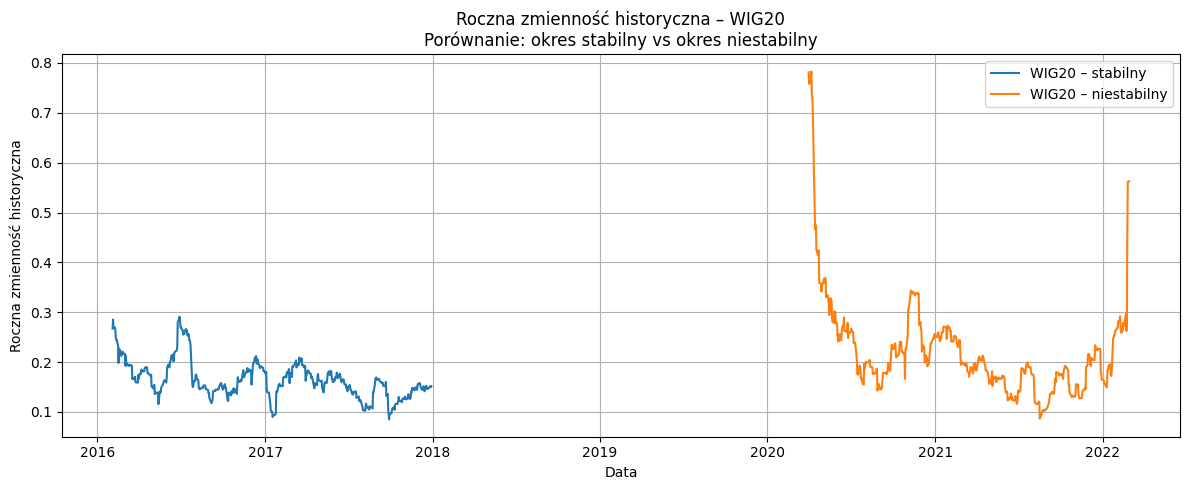

In [11]:
# Wykres porównawczy zmienności dla indeksu WIG20
plot_rv_two_regimes('wig20', periods_labels=('stabilny','niestabilny'),
                    processed_dir='indeksy_przetworzone', rv_col='RV_21')

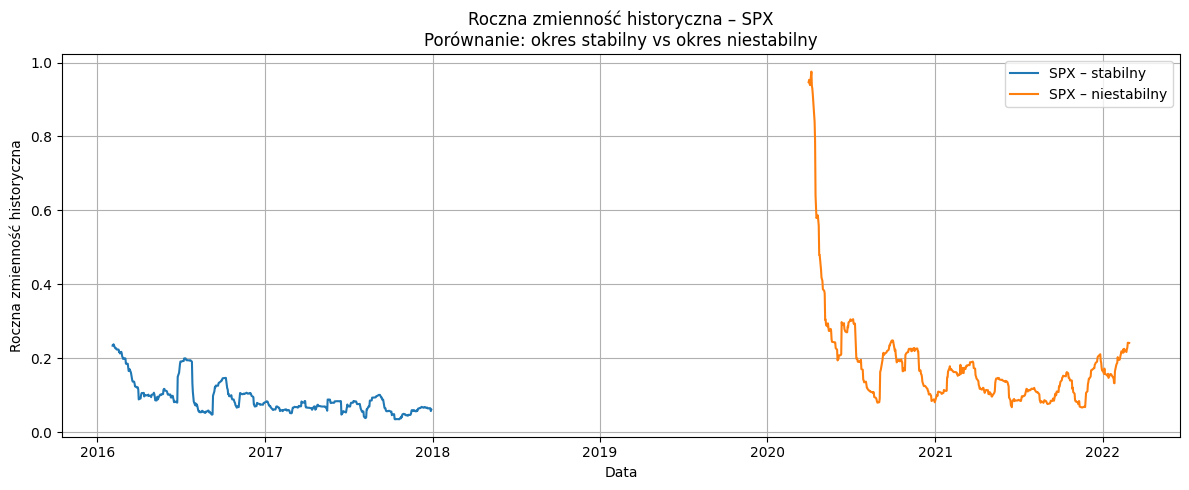

In [12]:
# Wykres porównawczy zmienności dla indeksu S&P 500
plot_rv_two_regimes('spx', periods_labels=('stabilny','niestabilny'),
                    processed_dir='indeksy_przetworzone', rv_col='RV_21')

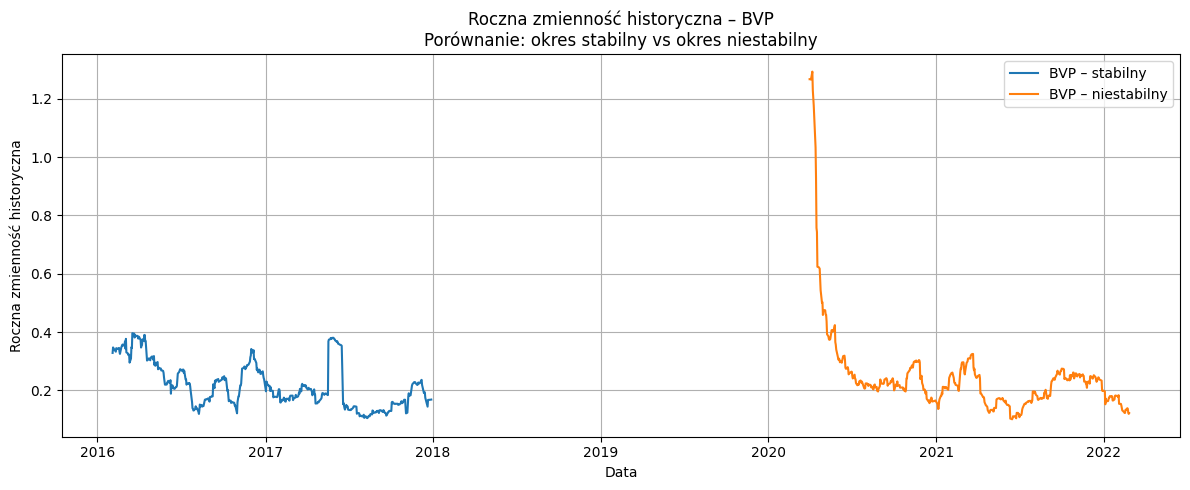

In [13]:
# Wykres porównawczy zmienności dla indeksu BOVESPA
plot_rv_two_regimes('bvp', periods_labels=('stabilny','niestabilny'),
                    processed_dir='indeksy_przetworzone', rv_col='RV_21')

## Obliczenie dodatkowych zmiennych technicznych do budowy Random Forest

In [14]:
# Dodanie kolumny Zamknięcie do danych FULL
add_close_to_processed(
    tickers=('WIG20', 'SPX', 'BVP'),
    periods=('stabilny', 'niestabilny'),
    full_dir='indeksy_full',                
    processed_dir='indeksy_przetworzone'
)

Zaktualizowano indeksy_przetworzone\stabilny\WIG20_stabilny_processed.csv (dodano kolumnę 'Zamkniecie')
Zaktualizowano indeksy_przetworzone\niestabilny\WIG20_niestabilny_processed.csv (dodano kolumnę 'Zamkniecie')
Zaktualizowano indeksy_przetworzone\stabilny\SPX_stabilny_processed.csv (dodano kolumnę 'Zamkniecie')
Zaktualizowano indeksy_przetworzone\niestabilny\SPX_niestabilny_processed.csv (dodano kolumnę 'Zamkniecie')
Zaktualizowano indeksy_przetworzone\stabilny\BVP_stabilny_processed.csv (dodano kolumnę 'Zamkniecie')
Zaktualizowano indeksy_przetworzone\niestabilny\BVP_niestabilny_processed.csv (dodano kolumnę 'Zamkniecie')


In [15]:
# Dodanie zmiennych technicznych do zbioru danych dla Random Forest
df = pd.read_csv('indeksy_przetworzone/niestabilny/SPX_niestabilny_processed.csv')
df['Data'] = pd.to_datetime(df['Data'])

df_feat = add_tech_features(df, price_col='Zamkniecie')
df_feat[['Data', 'Zamkniecie', 'MA_21', 'RSI_14', 'MACD_diff']].tail(10)

,Data,Zamkniecie,MA_21,RSI_14,MACD_diff
493,2022-02-14,4401.67,4479.746667,53.083238,1.562608
494,2022-02-15,4471.07,4470.614286,57.607385,2.744737
495,2022-02-16,4475.01,4465.752381,59.559429,3.953936
496,2022-02-17,4380.26,4458.490476,46.633078,-1.190462
497,2022-02-18,4348.87,4452.116190,38.324788,-6.001293
498,2022-02-22,4304.76,4447.679048,33.370017,-11.148942
499,2022-02-23,4225.50,4438.887143,26.165898,-18.455634
500,2022-02-24,4288.70,4435.660952,36.794380,-17.599015
501,2022-02-25,4384.65,4437.314286,42.642353,-9.540556
502,2022-02-28,4373.94,4439.572857,42.967001,-4.175607


# Modele ekonometryczne

## Wyniki prognozowania zmienności za pomocą modelu HAR

[OK] HAR zrobiony: WIG20, stabilny (n=248), R²=0.911
[OK] HAR zrobiony: WIG20, stabilny (n=248)
[OK] HAR zrobiony: WIG20, niestabilny (n=249), R²=0.909
[OK] HAR zrobiony: WIG20, niestabilny (n=249)
[OK] HAR zrobiony: SPX, stabilny (n=250), R²=0.872
[OK] HAR zrobiony: SPX, stabilny (n=250)
[OK] HAR zrobiony: SPX, niestabilny (n=251), R²=0.970
[OK] HAR zrobiony: SPX, niestabilny (n=251)
[OK] HAR zrobiony: BVP, stabilny (n=242), R²=0.914
[OK] HAR zrobiony: BVP, stabilny (n=242)
[OK] HAR zrobiony: BVP, niestabilny (n=243), R²=0.961
[OK] HAR zrobiony: BVP, niestabilny (n=243)
 METRYKI HAR
WIG20 – stabilny: {'RMSE': 0.008201531605521338, 'MAE': 0.005482506298920473}
WIG20 – niestabilny: {'RMSE': 0.01767314033263064, 'MAE': 0.007991596672081422}
SPX – stabilny: {'RMSE': 0.005261211788890244, 'MAE': 0.0031251907014635868}
SPX – niestabilny: {'RMSE': 0.00730299659781412, 'MAE': 0.004704676434656907}
BVP – stabilny: {'RMSE': 0.01942641577119975, 'MAE': 0.0073307635772314585}
BVP – niestabilny: {

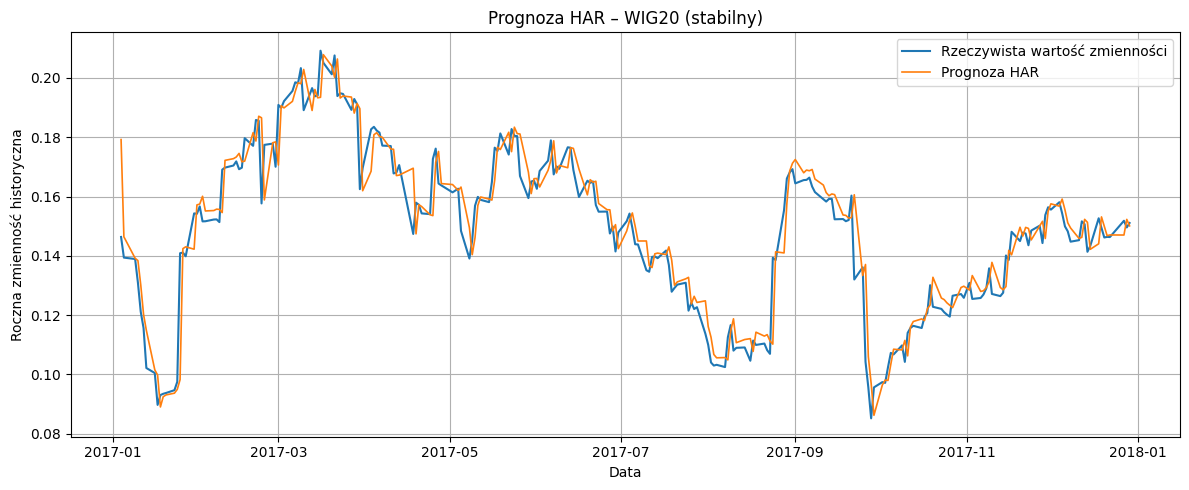

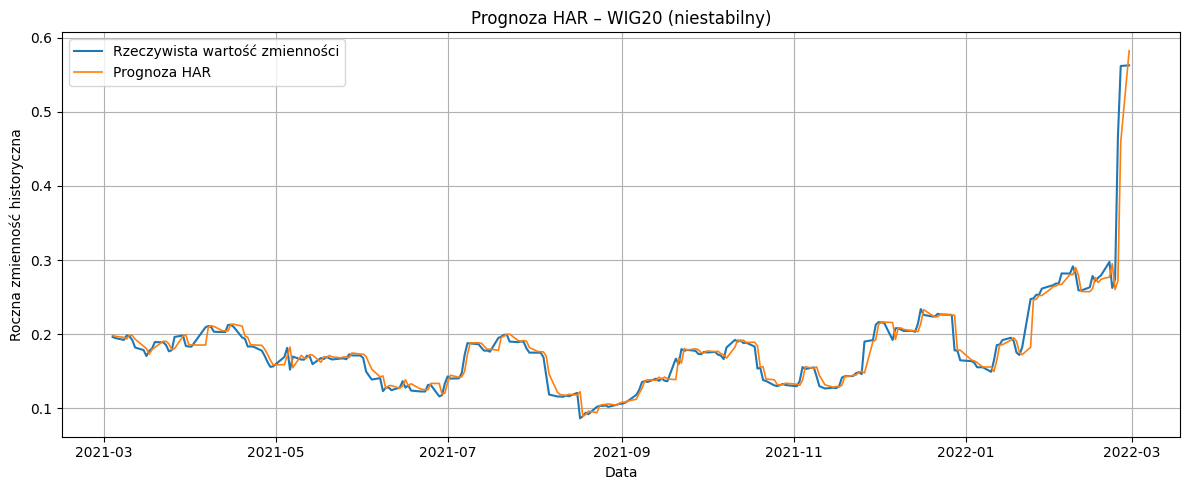

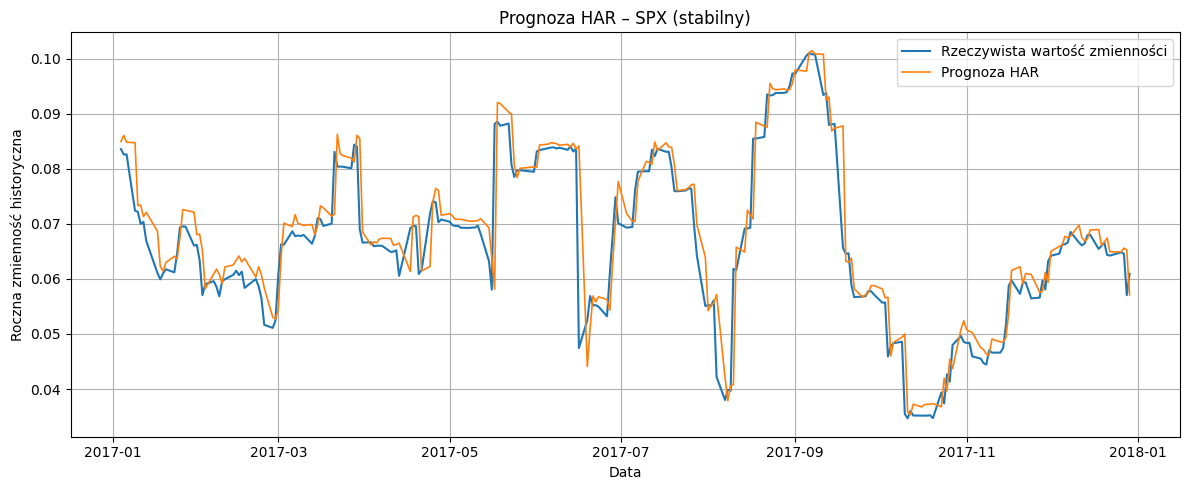

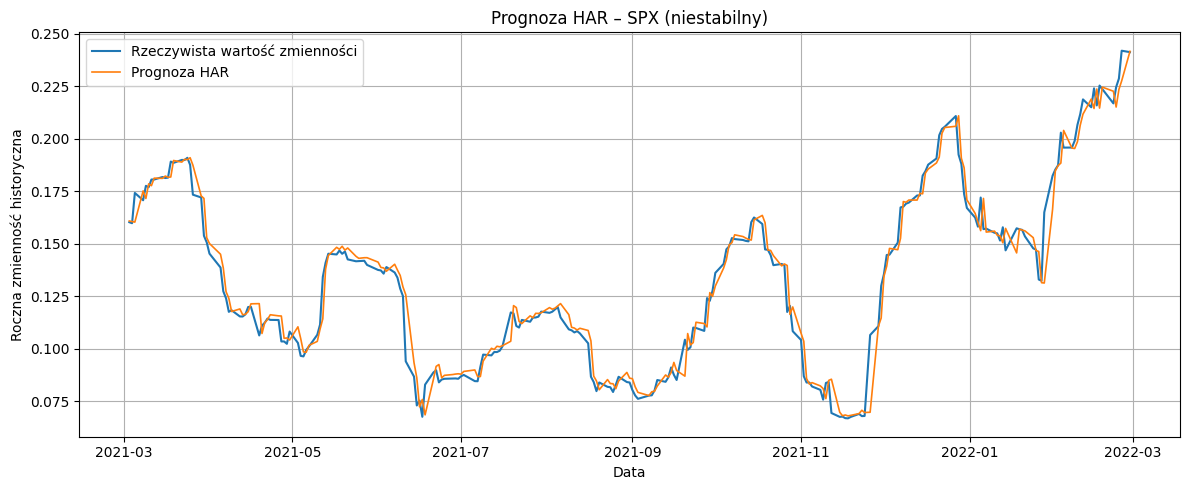

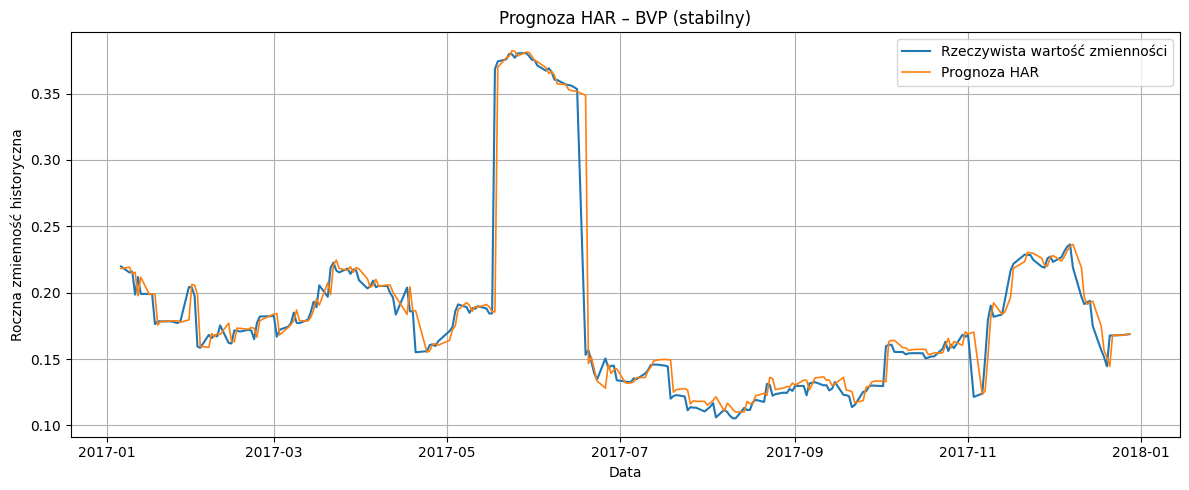

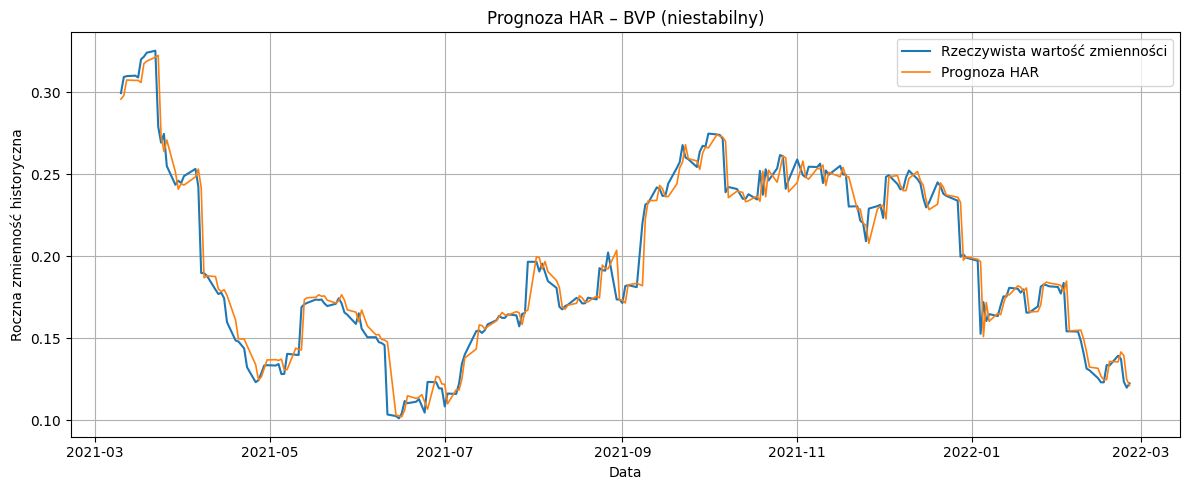

In [16]:
tickers = ('WIG20','SPX','BVP')
periods = ('stabilny','niestabilny')

har_res = har_predict_all(tickers=tickers, periods=periods,
                          base_dir='indeksy_przetworzone',
                          rv_col='RV_21', initial_train_size=252)

show_metrics_for_all(har_res, header=" METRYKI HAR")
plot_all_results(har_res, model_label='Prognoza HAR')

## Wyniki prognozowania zmienności za pomocą modelu GARCH(1,1)

[OK] GARCH zrobiony: WIG20, stabilny (n=248)
[OK] GARCH zrobiony: WIG20, niestabilny (n=249)
[OK] GARCH zrobiony: SPX, stabilny (n=250)
[OK] GARCH zrobiony: SPX, niestabilny (n=251)
[OK] GARCH zrobiony: BVP, stabilny (n=242)
[OK] GARCH zrobiony: BVP, niestabilny (n=243)
METRYKI GARCH
WIG20 – stabilny: {'RMSE': 0.026663962151136825, 'MAE': 0.019945873238565674}
WIG20 – niestabilny: {'RMSE': 0.0412386922267695, 'MAE': 0.03299868433632199}
SPX – stabilny: {'RMSE': 0.023923048336643403, 'MAE': 0.021007541125178147}
SPX – niestabilny: {'RMSE': 0.030545544937739224, 'MAE': 0.025716104495203593}
BVP – stabilny: {'RMSE': 0.05830015000282424, 'MAE': 0.046916699012107176}
BVP – niestabilny: {'RMSE': 0.03782775934516343, 'MAE': 0.0321885607100949}


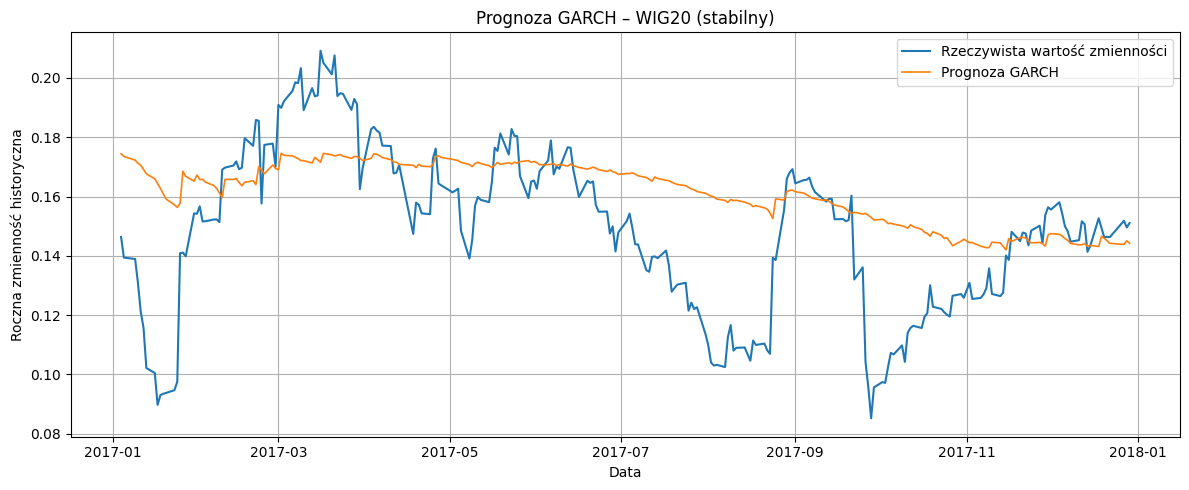

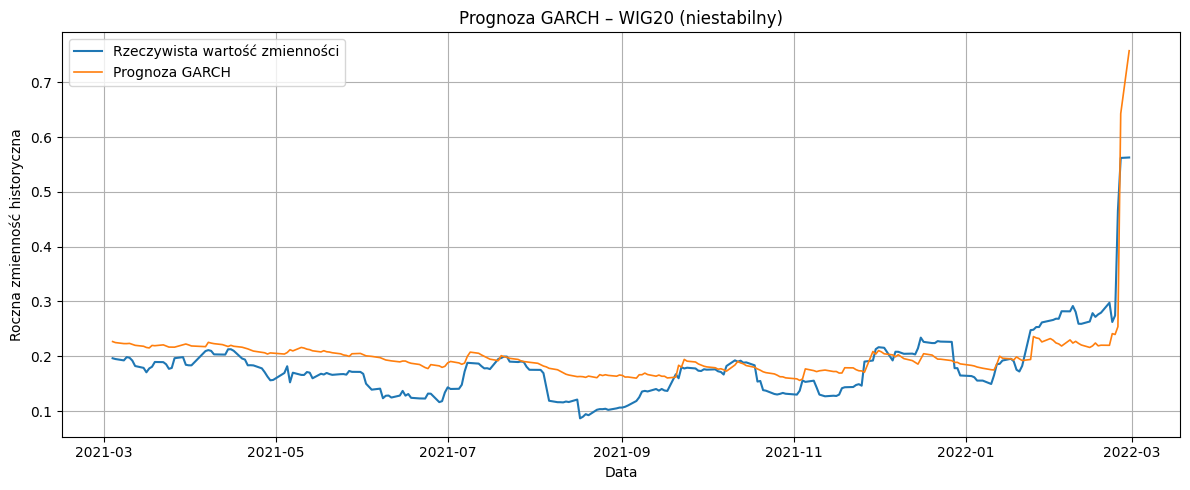

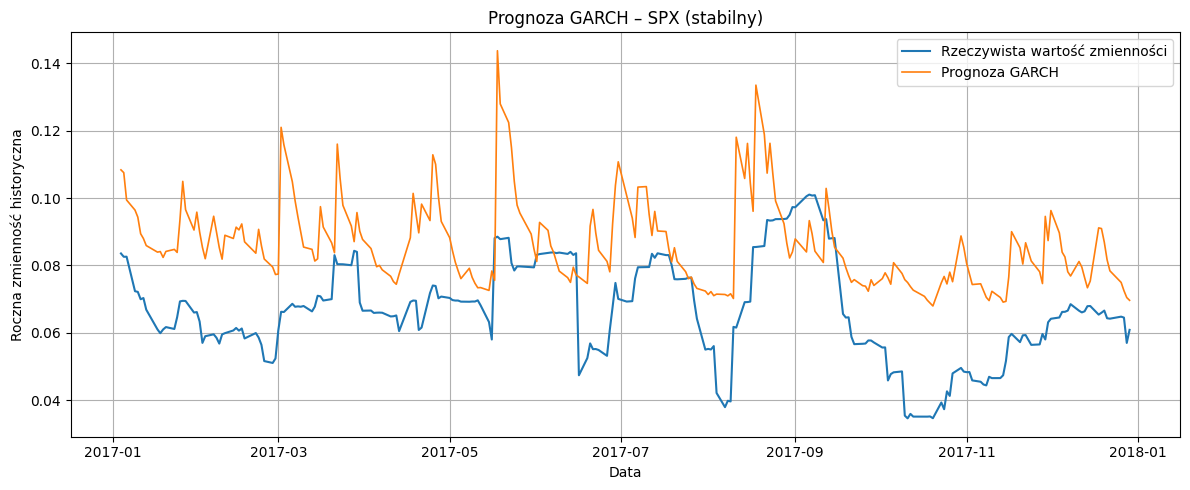

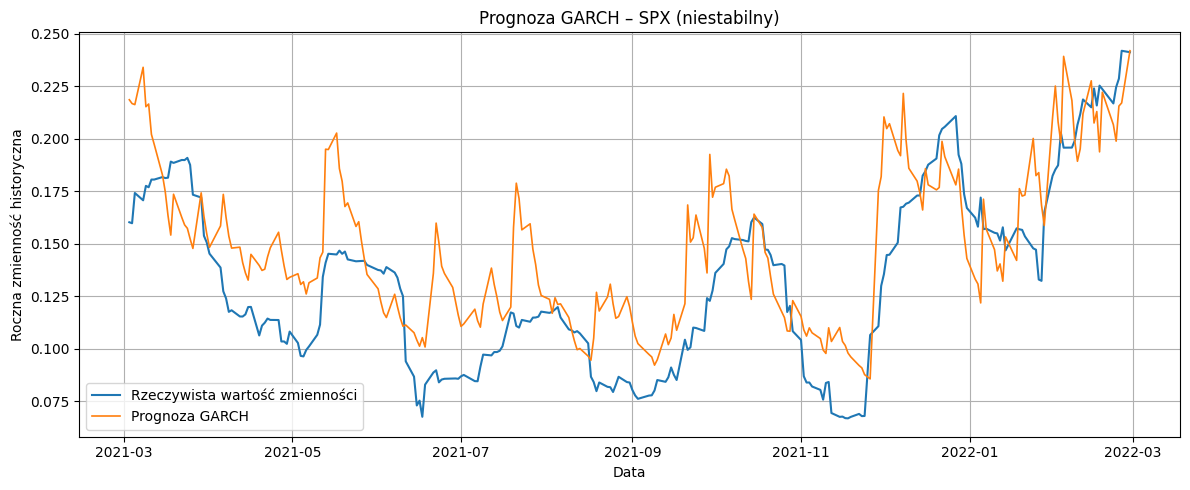

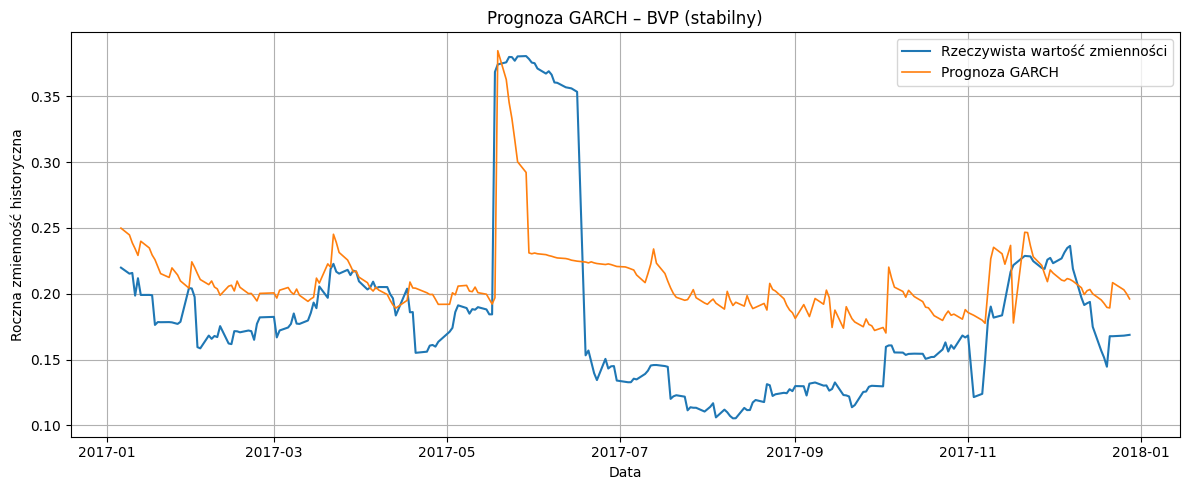

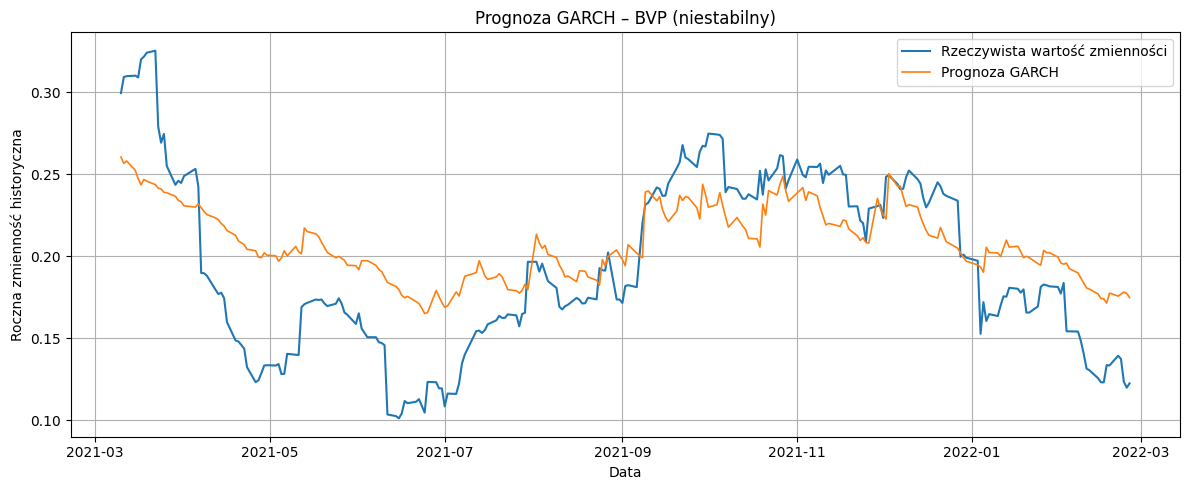

In [17]:
tickers = ('WIG20','SPX','BVP')
periods = ('stabilny','niestabilny')

garch_res = garch_predict_all(
    tickers=tickers, periods=periods,
    base_dir='indeksy_przetworzone',
    rv_col='RV_21', ret_col='Log_stopa_zwrotu',
    initial_train_size=252,
    scale_factor=100.0,      
    mean_spec='Zero',        # założenie o średniej równiej zero dla logarytmicznych stóp zwrotu
    dist='normal',           # założenie o rozkładzie normalnym
    annualize=True
)

show_metrics_for_all(garch_res, header="METRYKI GARCH")
plot_all_results(garch_res, model_label='Prognoza GARCH')

# Algorytm uczenia maszynowego

## Wyniki prognozowania zmienności za pomocą Random Forest

[OK] RF(selected) zrobiony: WIG20, stabilny (n=248)
[OK] RF(selected) zrobiony: WIG20, niestabilny (n=249)
[OK] RF(selected) zrobiony: SPX, stabilny (n=250)
[OK] RF(selected) zrobiony: SPX, niestabilny (n=251)
[OK] RF(selected) zrobiony: BVP, stabilny (n=242)
[OK] RF(selected) zrobiony: BVP, niestabilny (n=243)
=== METRYKI RF ===
WIG20 – stabilny: {'RMSE': 0.009397470919482887, 'MAE': 0.006619237583209042}
WIG20 – niestabilny: {'RMSE': 0.02047456231896062, 'MAE': 0.009922401033622012}
SPX – stabilny: {'RMSE': 0.0059629032785078325, 'MAE': 0.00359193846092832}
SPX – niestabilny: {'RMSE': 0.008312996390578713, 'MAE': 0.005928204252890675}
BVP – stabilny: {'RMSE': 0.021306067700216404, 'MAE': 0.008709384374159745}
BVP – niestabilny: {'RMSE': 0.012057358109810476, 'MAE': 0.007846953141829397}


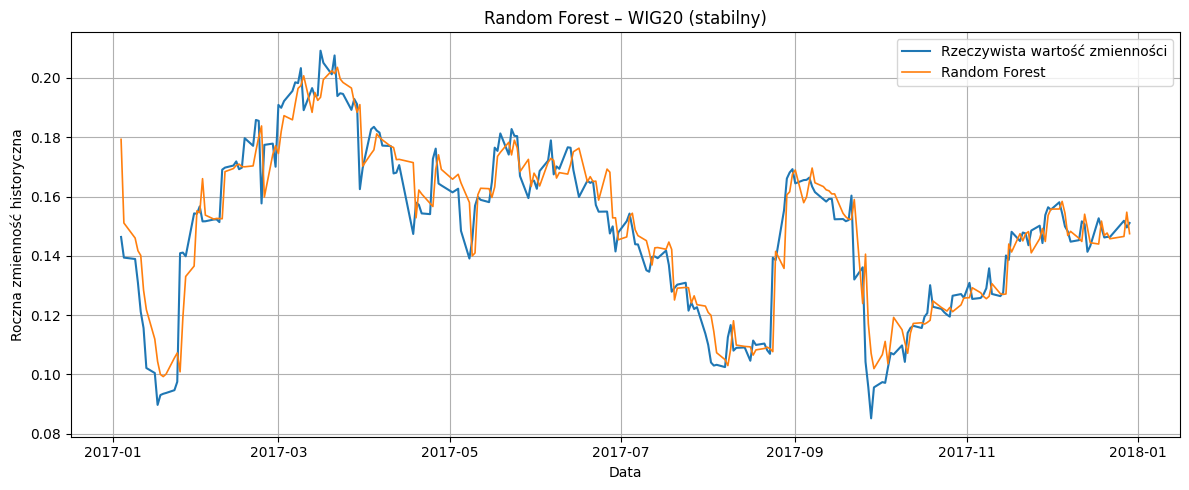

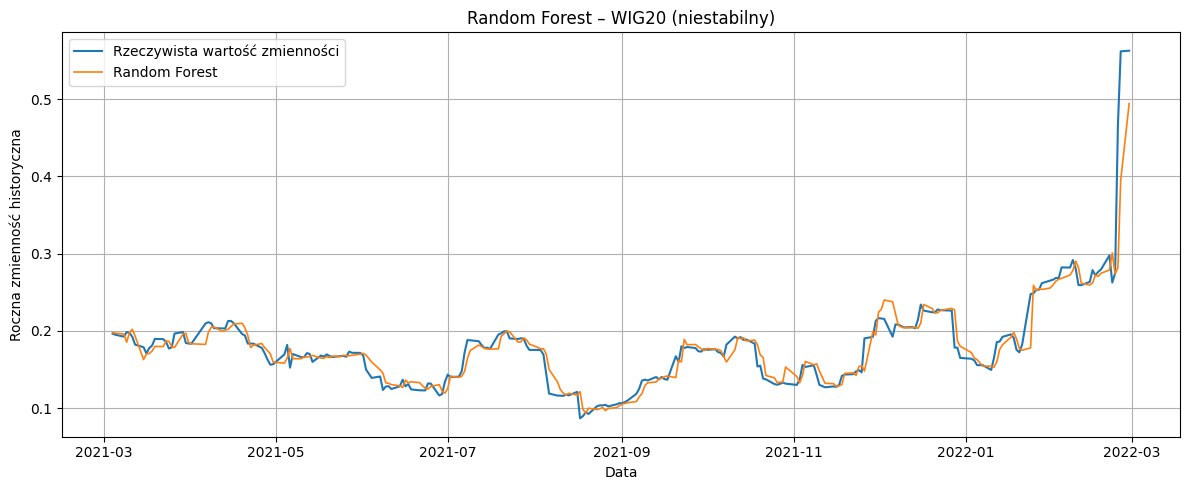

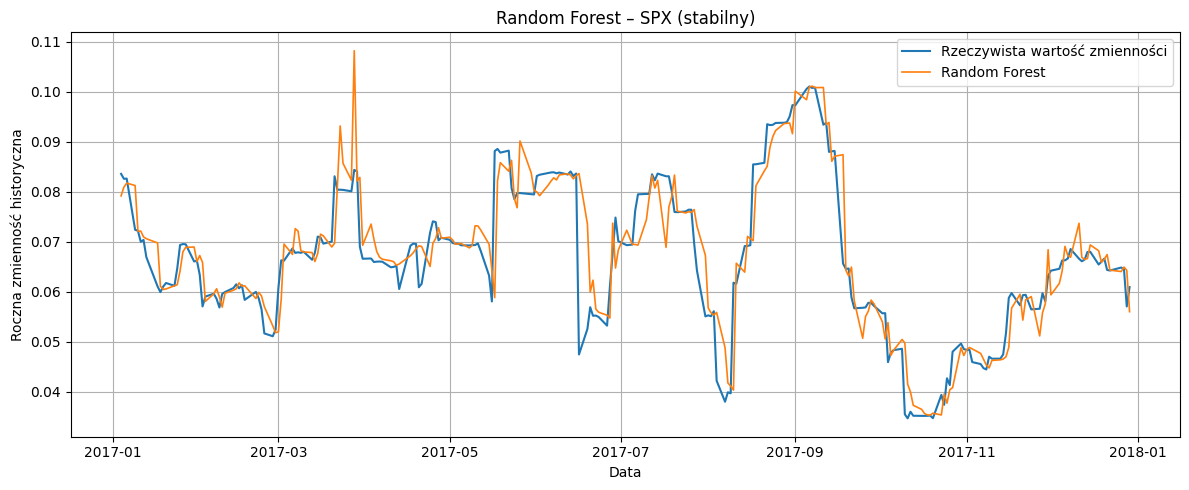

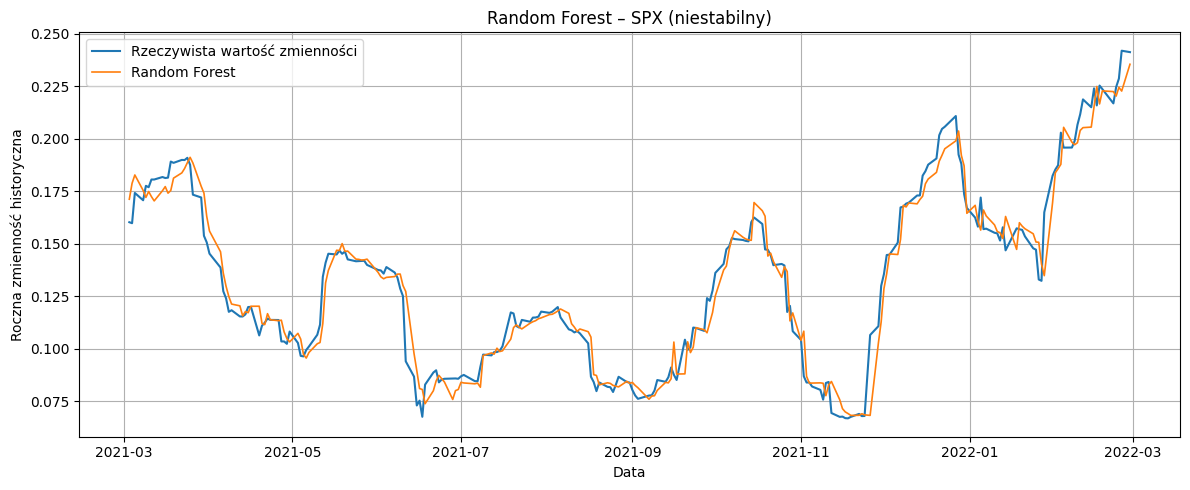

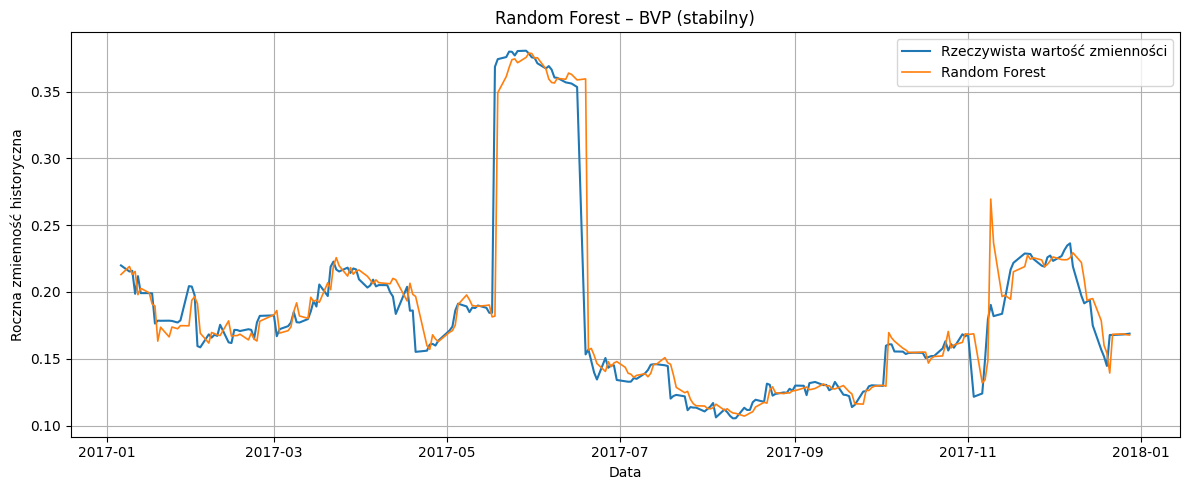

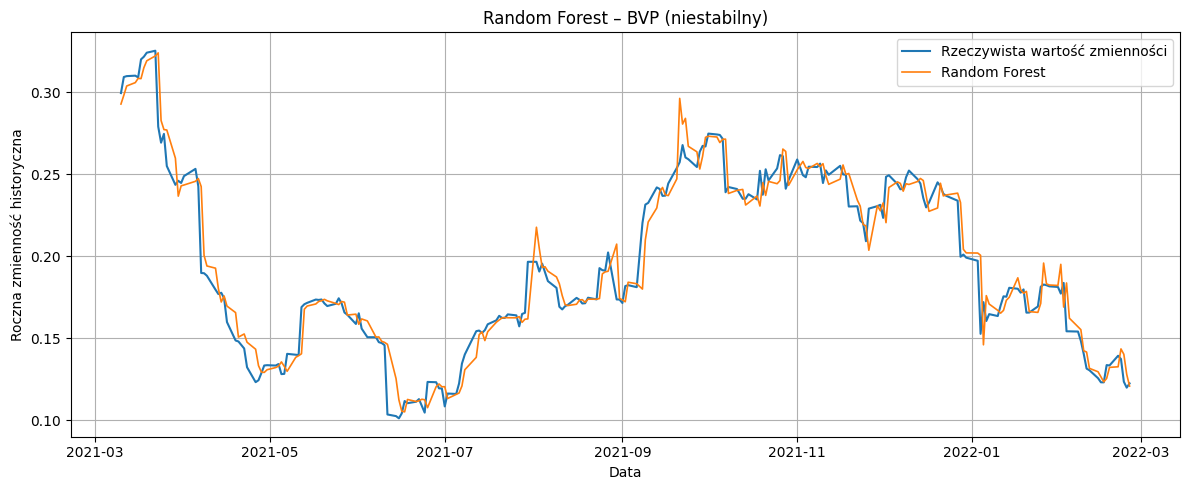

In [18]:
tickers = ('WIG20','SPX','BVP')
periods = ('stabilny','niestabilny')

rf_sel_safe = rf_predict_all_selected(
    tickers=tickers, periods=periods,
    base_dir='indeksy_przetworzone',
    rv_col='RV_21',
    initial_train_size=252,
    n_estimators=500,
    random_state=42
)

show_metrics_for_all(rf_sel_safe, header="=== METRYKI RF ===")
plot_all_results(rf_sel_safe, model_label='Random Forest')

# Diagnostyka i jakość dopasowania modeli

In [23]:
diag_table, details = quick_all_diagnostics(
    har_results=har_res,          # <- użyj swoich nazw!
    garch_results=garch_res,
    rf_results=rf_sel_safe,
    base_dir='indeksy_przetworzone',
    tickers=('WIG20','SPX','BVP'),
    periods=('stabilny','niestabilny'),
    rv_col='RV_21',
    ret_col='Log_stopa_zwrotu',
    price_col='Zamkniecie',
    lb_lags=20
)

In [ ]:
# Dodatkowe obliczenie R kwadrat dla modeli HAR
r2_map = { (k[0], k[1]): v.get('r2', np.nan) for k, v in har_res.items() }
# Utworzenie kolumny i wypełnienie jej tylko dla wierszy HAR
diag_table['R^2 (HAR)'] = np.nan
mask_har = diag_table['Model'].eq('HAR-RV')
diag_table.loc[mask_har, 'R^2 (HAR)'] = diag_table.loc[mask_har].apply(
    lambda r: r2_map.get((r['Indeks'], r['Okres']), np.nan), axis=1
)
# zapis tabeli z wynikami do pliku csv
diag_table.to_csv("diag_table.csv", index=False)